In [39]:
import pandas as pd 
import numpy as np
import os

%load_ext autoreload
%autoreload 2

import sys
sys.path.append(os.path.dirname(os.getcwd()))

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

## LLM

In [40]:
from climateqa.engine.llm import get_llm
from climateqa.engine.llm.ollama import get_llm as get_llm_ollama

llm = get_llm(provider="openai")
llm.invoke("Say Hello !")


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Hello! How can I assist you today?', response_metadata={'finish_reason': 'stop'}, id='run-1e3aee01-7ae5-4ac8-88b2-294e7848f1ee-0')

## Retriever 

In [41]:
from climateqa.engine.vectorstore import get_pinecone_vectorstore
from climateqa.engine.embeddings import get_embeddings_function
from climateqa.knowledge.retriever import ClimateQARetriever

question = "What is the impact of climate change on the environment?"

embeddings_function = get_embeddings_function()
vectorstore_ipcc = get_pinecone_vectorstore(embeddings_function)
docs_question = vectorstore_ipcc.search(query = question, search_type="similarity")
docs_question

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


Loading embeddings model:  BAAI/bge-base-en-v1.5


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['/home/tim/anaconda3/envs/climateqa/lib/python3.11/site-packages/pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone


[Document(metadata={'chunk_type': 'text', 'document_id': 'document6', 'document_number': 6.0, 'element_id': 'N/A', 'figure_code': 'N/A', 'file_size': 'N/A', 'image_path': 'N/A', 'n_pages': 3068.0, 'name': 'Full Report. In: Climate Change 2022: Impacts, Adaptation and Vulnerability. Contribution of the WGII to the AR6 of the IPCC', 'num_characters': 1152.0, 'num_tokens': 223.0, 'num_tokens_approx': 285.0, 'num_words': 214.0, 'page_number': 2516.0, 'release_date': 2022.0, 'report_type': 'Full Report', 'section_header': '(a) Low-lying coastal systems', 'short_name': 'IPCC AR6 WGII FR', 'source': 'IPCC', 'toc_level0': 'Chapters and Cross-Chapter Papers ', 'toc_level1': 'Chapter 16  Key Risks across Sectors and Regions', 'toc_level2': 'N/A', 'toc_level3': 'N/A', 'url': 'https://report.ipcc.ch/ar6/wg2/IPCC_AR6_WGII_FullReport.pdf'}, page_content="'Impact of climate change' is defined as the difference between the observed state of the system and the state of \r\nthe system assuming the same 

In [44]:
docs_question[0].metadata

{'chunk_type': 'text',
 'document_id': 'document6',
 'document_number': 6.0,
 'element_id': 'N/A',
 'figure_code': 'N/A',
 'file_size': 'N/A',
 'image_path': 'N/A',
 'n_pages': 3068.0,
 'name': 'Full Report. In: Climate Change 2022: Impacts, Adaptation and Vulnerability. Contribution of the WGII to the AR6 of the IPCC',
 'num_characters': 1152.0,
 'num_tokens': 223.0,
 'num_tokens_approx': 285.0,
 'num_words': 214.0,
 'page_number': 2516.0,
 'release_date': 2022.0,
 'report_type': 'Full Report',
 'section_header': '(a) Low-lying coastal systems',
 'short_name': 'IPCC AR6 WGII FR',
 'source': 'IPCC',
 'toc_level0': 'Chapters and Cross-Chapter Papers ',
 'toc_level1': 'Chapter 16  Key Risks across Sectors and Regions',
 'toc_level2': 'N/A',
 'toc_level3': 'N/A',
 'url': 'https://report.ipcc.ch/ar6/wg2/IPCC_AR6_WGII_FullReport.pdf'}

In [7]:
# optional filters
sources_owid = ["OWID"]
filters = {}
filters["source"] = {"$in": sources_owid}

# vectorestore_graphs
vectorstore_graphs = get_pinecone_vectorstore(embeddings_function, index_name = os.getenv("PINECONE_API_INDEX_OWID"), text_key="title")
owid_graphs = vectorstore_graphs.search(query = question, search_type="similarity")
owid_graphs = vectorstore_graphs.similarity_search_with_score(query = question, filter=filters, k=5)
owid_graphs

[(Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_349', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/co2-emissions-and-gdp?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Consumption-based emissions are national emissions that have been adjusted for trade. This measures fossil fuel and industry emissions. Land-use change is not included.', 'url': 'https://ourworldindata.org/grapher/co2-emissions-and-gdp'}, page_content='Change in CO2 emissions and GDP'),
  0.668701708),
 (Document(metadata={'category': 'Climate Change', 'doc_id': 'owid_766', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or

In [11]:
from climateqa.knowledge.retriever import ClimateQARetriever

sources = ["IPCC"]
k_summary = 5
k_before_reranking = 10
config={}
# Search the document store using the retriever
# Configure high top k for further reranking step
retriever = ClimateQARetriever(
    vectorstore=vectorstore_ipcc,
    sources = sources,
    min_size = 200,
    k_summary = k_summary,
    k_total = k_before_reranking,
    threshold = 0.5,
)
docs_question = await retriever.ainvoke(question,config)

In [14]:
vectorstore_ipcc.similarity_search_with_score(query=question,filter = {"chunk_type": "image"},k = 15)

[(Document(metadata={'chunk_type': 'image', 'document_id': 'document10', 'document_number': 10.0, 'element_id': 'Picture_0_12', 'figure_code': 'N/A', 'file_size': 109.03125, 'image_path': '/dbfs/mnt/ai4sclqa/raw/climateqa/documents/document10/images/Picture_0_12.png', 'n_pages': 36.0, 'name': 'Synthesis report of the IPCC Sixth Assesment Report AR6', 'num_characters': 'N/A', 'num_tokens': 'N/A', 'num_tokens_approx': 'N/A', 'num_words': 'N/A', 'page_number': 12.0, 'release_date': 2023.0, 'report_type': 'SPM', 'section_header': 'N/A', 'short_name': 'IPCC AR6 SYR', 'source': 'IPCC', 'toc_level0': 'N/A', 'toc_level1': 'N/A', 'toc_level2': 'N/A', 'toc_level3': 'N/A', 'url': 'https://www.ipcc.ch/report/ar6/syr/downloads/report/IPCC_AR6_SYR_SPM.pdf'}, page_content='Summary: This image provides a visual summary of the impacts of climate change on various aspects such as health, well-being, agriculture, water availability, and ecosystems. It shows the relationships between physical climate cond

In [13]:
vectorstore_ipcc.similarity_search_with_score(query=question,filter = {"chunk_type": "text"},k = 15)

[(Document(metadata={'chunk_type': 'text', 'document_id': 'document6', 'document_number': 6.0, 'element_id': 'N/A', 'figure_code': 'N/A', 'file_size': 'N/A', 'image_path': 'N/A', 'n_pages': 3068.0, 'name': 'Full Report. In: Climate Change 2022: Impacts, Adaptation and Vulnerability. Contribution of the WGII to the AR6 of the IPCC', 'num_characters': 1152.0, 'num_tokens': 223.0, 'num_tokens_approx': 285.0, 'num_words': 214.0, 'page_number': 2516.0, 'release_date': 2022.0, 'report_type': 'Full Report', 'section_header': '(a) Low-lying coastal systems', 'short_name': 'IPCC AR6 WGII FR', 'source': 'IPCC', 'toc_level0': 'Chapters and Cross-Chapter Papers ', 'toc_level1': 'Chapter 16  Key Risks across Sectors and Regions', 'toc_level2': 'N/A', 'toc_level3': 'N/A', 'url': 'https://report.ipcc.ch/ar6/wg2/IPCC_AR6_WGII_FullReport.pdf'}, page_content="'Impact of climate change' is defined as the difference between the observed state of the system and the state of \r\nthe system assuming the same

In [12]:
docs_question

[Document(metadata={'chunk_type': 'image', 'document_id': 'document10', 'document_number': 10.0, 'element_id': 'Picture_0_12', 'figure_code': 'N/A', 'file_size': 109.03125, 'image_path': '/dbfs/mnt/ai4sclqa/raw/climateqa/documents/document10/images/Picture_0_12.png', 'n_pages': 36.0, 'name': 'Synthesis report of the IPCC Sixth Assesment Report AR6', 'num_characters': 'N/A', 'num_tokens': 'N/A', 'num_tokens_approx': 'N/A', 'num_words': 'N/A', 'page_number': 13, 'release_date': 2023.0, 'report_type': 'SPM', 'section_header': 'N/A', 'short_name': 'IPCC AR6 SYR', 'source': 'IPCC', 'toc_level0': 'N/A', 'toc_level1': 'N/A', 'toc_level2': 'N/A', 'toc_level3': 'N/A', 'url': 'https://www.ipcc.ch/report/ar6/syr/downloads/report/IPCC_AR6_SYR_SPM.pdf', 'similarity_score': 0.716457784, 'content': 'Summary: This image provides a visual summary of the impacts of climate change on various aspects such as health, well-being, agriculture, water availability, and ecosystems. It shows the relationships be

In [ ]:
# from climateqa.knowledge.retriever import ClimateQARetriever

# # Search the document store using the retriever
# retriever = GraphRetriever(
#     vectorstore = vectorstore,
#     sources = sources,
#     k_total = k_before_reranking,
#     threshold = 0.5,
#     )
# docs_question = retriever.get_relevant_documents(question)

## Reranker

In [9]:
from climateqa.engine.reranker import get_reranker
from climateqa.engine.reranker import rerank_docs

reranker = get_reranker("nano")
reranked_docs_question = rerank_docs(reranker,docs_question,question)
reranked_docs_question

Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


[Document(metadata={'chunk_type': 'text', 'document_id': 'document6', 'document_number': 6.0, 'element_id': 'N/A', 'figure_code': 'N/A', 'file_size': 'N/A', 'image_path': 'N/A', 'n_pages': 3068.0, 'name': 'Full Report. In: Climate Change 2022: Impacts, Adaptation and Vulnerability. Contribution of the WGII to the AR6 of the IPCC', 'num_characters': 1152.0, 'num_tokens': 223.0, 'num_tokens_approx': 285.0, 'num_words': 214.0, 'page_number': 2516.0, 'release_date': 2022.0, 'report_type': 'Full Report', 'section_header': '(a) Low-lying coastal systems', 'short_name': 'IPCC AR6 WGII FR', 'source': 'IPCC', 'toc_level0': 'Chapters and Cross-Chapter Papers ', 'toc_level1': 'Chapter 16  Key Risks across Sectors and Regions', 'toc_level2': 'N/A', 'toc_level3': 'N/A', 'url': 'https://report.ipcc.ch/ar6/wg2/IPCC_AR6_WGII_FullReport.pdf', 'reranking_score': 0.9995266199111938, 'query_used_for_retrieval': 'What is the impact of climate change on the environment?'}, page_content="'Impact of climate c

# Graph

---- Translate query ----


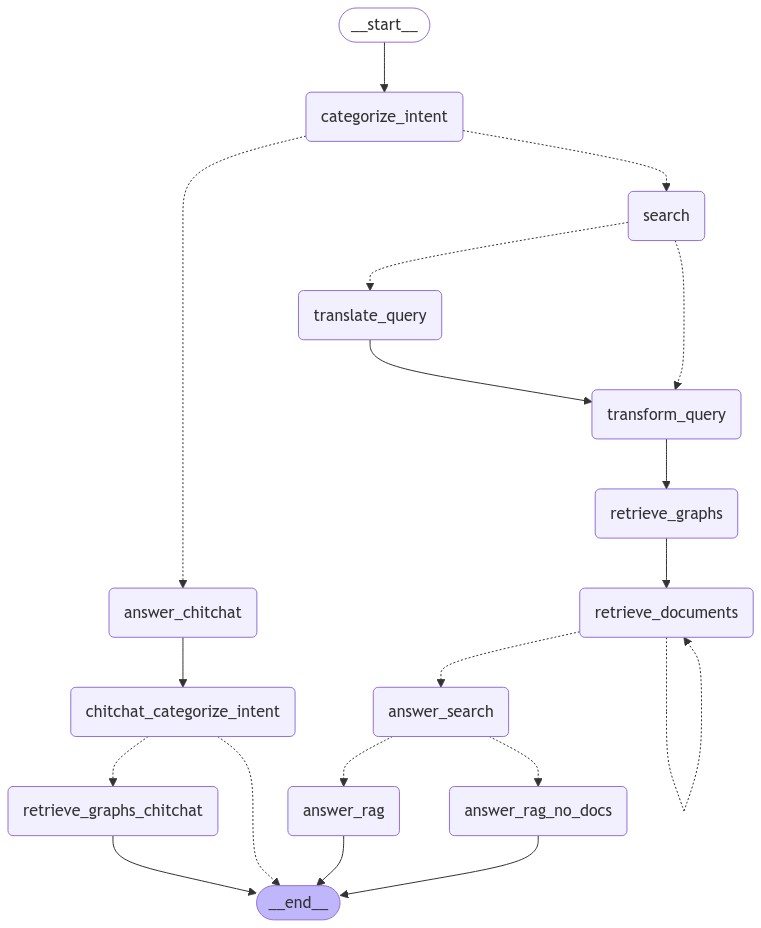

In [10]:
from climateqa.engine.graph import make_graph_agent, display_graph

app = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore_ipcc, vectorstore_graphs=vectorstore_graphs, reranker=reranker)
display_graph(app)

In [11]:
from climateqa.engine.graph import search 

from climateqa.engine.chains.intent_categorization import make_intent_categorization_node


from climateqa.engine.chains.answer_chitchat import make_chitchat_node
from climateqa.engine.chains.answer_ai_impact import make_ai_impact_node
from climateqa.engine.chains.query_transformation import make_query_transform_node
from climateqa.engine.chains.translation import make_translation_node
from climateqa.engine.chains.retrieve_documents import make_retriever_node
from climateqa.engine.chains.answer_rag import make_rag_node
from climateqa.engine.chains.graph_retriever import make_graph_retriever_node
from climateqa.engine.chains.chitchat_categorization import make_chitchat_intent_categorization_node
from climateqa.engine.chains.prompts import audience_prompts
from climateqa.engine.graph import route_intent


In [ ]:
inial_state = {"user_input": "What is the impact of climate change on the environment?", "audience" : audience_prompts["general"],"sources_input":["IPCC"]}
state=inial_state.copy()

In [13]:
cat_node = make_intent_categorization_node(llm)
state.update(cat_node(inial_state))
state

---- Categorize_message ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Output intent categorization: {'intent': 'search'}



{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC'],
 'intent': 'search',
 'language': 'English',
 'query': 'What is the impact of climate change on the environment?'}

In [14]:
state.update(search(state))
state

{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC'],
 'intent': 'search',
 'language': 'English',
 'query': 'What is the impact of climate change on the environment?'}

In [15]:
intent = route_intent(state)

if route_intent(state) == "translate_query":
    make_translation_node(llm)(state)

In [16]:
state.update(make_query_transform_node(llm)(state))
state

---- Transform query ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC'],
 'intent': 'search',
 'language': 'English',
 'query': 'What is the impact of climate change on the environment?',
 'remaining_questions': [{'question': 'What are the effects of climate change on ecosystems?',
   'sources': ['IPCC'],
   'index': 'Vector'},
  {'question': 'How does climate change affect biodiversity and wildlife?',
   'sources': ['IPCC'],
   'index': 'Vector'}],
 'n_questions': 2}

In [17]:
state.update(make_graph_retriever_node(vectorstore_graphs, reranker)(state))
state

---- Retrieving graphs ----
Subquestion 0: What are the effects of climate change on ecosystems?


/home/tim/ai4s/climate_qa/climate-question-answering/climateqa/engine/chains/graph_retriever.py:91: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  docs_question = retriever.get_relevant_documents(question)


8 graphs retrieved for subquestion 1: [Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/contributions-global-temp-change', 'similarity_score': 0.649586797, 'content': 'Global warming: Contributions to the change in global mean surface temperature', 'reranking_score': 0.004589226096868515, 'query_used_for_retrieval': 'What are the effects of climate change on ecosystems?', 'sources_used': ['IEA', 'OWID']}, page_content='Global warming: Contributions to the change 

{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC'],
 'intent': 'search',
 'language': 'English',
 'query': 'What is the impact of climate change on the environment?',
 'remaining_questions': [{'question': 'What are the effects of climate change on ecosystems?',
   'sources': ['IPCC'],
   'index': 'Vector'},
  {'question': 'How does climate change affect biodiversity and wildlife?',
   'sources': ['IPCC'],
   'index': 'Vector'}],
 'n_questions': 2,
 'recommended_content': [Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-w

In [18]:
retriever_node = make_retriever_node(vectorstore_ipcc, reranker, llm)
retriever_node

<function climateqa.engine.chains.retrieve_documents.make_retriever_node.<locals>.retrieve_classical_docs(state, config)>

In [23]:
new_state = state.copy()
new_state.update(await retriever_node(state, {}))
# .append(await retriever_node(state,{})

---- Retrieve documents ----


In [ ]:
# new_state = state.copy()
# while len(new_state["remaining_questions"])>0:    
#     async for temp_state in retriever_node.astream(new_state):
#         new_state.update(temp_state)
#         print(temp_state)
# new_state

AttributeError: 'function' object has no attribute 'astream'

In [24]:
answer_rag = await make_rag_node(llm)(new_state,{})
new_state.update(answer_rag)

---- Answer RAG ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Answer:
Climate change has had significant and wide-ranging impacts on the environment, affecting various ecosystems across the globe. Here are some key points to understand:

### 1. **Ecosystem Alterations**
- Climate change has already led to substantial changes in terrestrial, freshwater, and ocean ecosystems. These changes are observable at both regional and local levels, affecting the structure of ecosystems, the geographic ranges of species, and the timing of seasonal life cycles (phenology) [Doc 6, Doc 7].

### 2. **Biodiversity Loss**
- There have been hundreds of local species losses driven by extreme heat events, with mass mortality recorded in both land and ocean ecosystems. Some impacts are nearing irreversibility, particularly in areas affected by glacier retreat and permafrost thaw [Doc 3].

### 3. **Coastal Ecosystems**
- Coastal ecosystems are particularly vulnerable, facing threats from ocean warming, acidification, and rising sea levels. These factors, combined with

In [27]:
inial_state

{'user_input': 'What is the impact of climate change on the environment?',
 'audience': 'the general public who know the basics in science and climate change and want to learn more about it without technical terms. Still use references to passages.',
 'sources_input': ['IPCC']}

In [38]:
event_list = app.astream_events(inial_state, version = "v1")

In [37]:

async for event in event_list:
    pass